# MLOps Assignment 2: Feature Stores & ML Pipelines

Anusha Bhat
July 17, 2025

## Libraries 

In [0]:
%pip install xgboost codecarbon shap databricks-feature-engineering

INFO: pip is looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-status to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 83.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/741.4 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 38.0 MB/s eta 0:00:00
   ━━━━━

In [0]:
%restart_python

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
import mlflow
import mlflow.sklearn
from databricks import feature_store
from databricks.feature_store import FeatureStoreClient
from codecarbon import EmissionsTracker
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tempfile
import os


## Load and Process Data 

In [0]:
data = pd.read_csv("/Workspace/Users/anushab@uchicago.edu/MLOps/athletes.csv")

data.head()

,athlete_id,name,region,team,affiliate,gender,age,height,weight,fran,helen,grace,filthy50,fgonebad,run400,run5k,candj,snatch,deadlift,backsq,pullups,eat,train,background,experience,schedule,howlong
0,2554.0,Pj Ablang,South West,Double Edge,Double Edge CrossFit,Male,24.0,70.0,166.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.0,NaN,400.0,305.0,NaN,NaN,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|I r...,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
1,3517.0,Derek Abdella,NaN,NaN,NaN,Male,42.0,70.0,190.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I have a coach who determines my programming|I...,I played youth or high school level sports|,I began CrossFit with a coach (e.g. at an affi...,I do multiple workouts in a day 2x a week|,4+ years|
2,4691.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5164.0,Abo Brandon,Southern California,LAX CrossFit,LAX CrossFit,Male,40.0,67.0,NaN,211.0,645.0,300.0,NaN,196.0,NaN,NaN,245.0,200.0,375.0,325.0,25.0,I eat 1-3 full cheat meals per week|,I workout mostly at a CrossFit Affiliate|I hav...,I played youth or high school level sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|,4+ years|
4,5286.0,Bryce Abbey,NaN,NaN,NaN,Male,32.0,65.0,149.0,206.0,465.0,NaN,1053.0,NaN,NaN,1081.0,205.0,150.0,NaN,325.0,50.0,I eat quality foods but don't measure the amount|,I workout mostly at a CrossFit Affiliate|I inc...,I played college sports|,I began CrossFit by trying it alone (without a...,I usually only do 1 workout a day|I strictly s...,1-2 years|


In [0]:
# clean data and store original copy 
data_cp = data.copy()

# remove not relevant columns
data_cp = data_cp.dropna(subset=['region','age','weight','height','howlong','gender','eat', 
                                 'train','background','experience','schedule','howlong', 
                                 'deadlift','candj','snatch','backsq','experience',
                                 'background','schedule','howlong'])
data_cp = data_cp.drop(columns=['affiliate','team','name','fran','helen','grace',
                                'filthy50','fgonebad','run400','run5k','pullups','train'])

# remove Outliers
data_cp = data_cp[data_cp['weight'] < 1500]
data_cp = data_cp[data_cp['gender'] != '--']
data_cp = data_cp[data_cp['age'] >= 18]
data_cp = data_cp[(data_cp['height'] < 96) & (data_cp['height'] > 48)]

data_cp = data_cp[
    ((data_cp['gender'] == 'Male') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 1105)) |
    ((data_cp['gender'] == 'Female') & (data_cp['deadlift'] > 0) & (data_cp['deadlift'] <= 636))
]
data_cp = data_cp[(data_cp['candj'] > 0) & (data_cp['candj'] <= 395)]
data_cp = data_cp[(data_cp['snatch'] > 0) & (data_cp['snatch'] <= 496)]
data_cp = data_cp[(data_cp['backsq'] > 0) & (data_cp['backsq'] <= 1069)]

# clean Survey Data
decline_dict = {'Decline to answer|': np.nan}
data_cp = data_cp.replace(decline_dict)
data_cp = data_cp.dropna(subset=['background','experience','schedule','howlong','eat'])

In [0]:
# create new features 

# calculate total lift
data_cp["total_lift"] = (data_cp["deadlift"] + data_cp["candj"] + 
                         data_cp["snatch"] + data_cp["backsq"])

# create relative lift cols 
data_cp['candj_rel'] = data_cp['candj'] / data_cp['weight']
data_cp['snatch_rel'] = data_cp['snatch'] / data_cp['weight']
data_cp['deadlift_rel'] = data_cp['deadlift'] / data_cp['weight']
data_cp['backsq_rel'] = data_cp['backsq'] / data_cp['weight']

# create bmi cols 
data_cp['BMI'] = (data_cp['weight'] * 703) / (data_cp['height'] ** 2)

# only retain final relevant cols 
data_cp = data_cp[['athlete_id', 'gender', 'age', 'height', 'weight', 'total_lift', 'candj_rel', 'snatch_rel', 'deadlift_rel', 'backsq_rel', 'BMI']]

In [0]:
data_cp.head()

,athlete_id,gender,age,height,weight,total_lift,candj_rel,snatch_rel,deadlift_rel,backsq_rel,BMI
21,21269.0,Male,30.0,71.0,200.0,1110.0,1.175000,0.875000,1.925000,1.575000,27.891291
22,21685.0,Male,28.0,70.0,176.0,910.0,1.062500,0.761364,1.903409,1.443182,25.250612
27,25464.0,Male,35.0,68.0,225.0,1335.0,1.266667,0.911111,1.955556,1.800000,34.207396
50,43767.0,Male,36.0,71.0,199.0,1354.0,1.341709,1.065327,2.437186,1.959799,27.751835
60,55504.0,Male,36.0,64.0,155.0,1225.0,1.580645,1.161290,2.677419,2.483871,26.602783


## Create Feature Store Tables 

In [0]:
# start Spark session
spark = SparkSession.builder.getOrCreate()

In [0]:
# convert df from pandas to Spark df
spark_df = spark.createDataFrame(data_cp)

In [0]:
# create the 2 data versions with different features 
v1_cols = ['athlete_id', 'gender', 'age', 'height', 'weight', 'total_lift']
df_v1 = spark_df.select(v1_cols)

# v2 will have BMI and relative lifts added on as features, whereas v1 has original cols
df_v2 = spark_df

In [0]:
# initialize Feature Store client
fs = feature_store.FeatureStoreClient()

In [0]:
# create feature tables

# table for v1
fs.create_table(
    name = "athletes_v1",
    primary_keys = ["athlete_id"],
    df = df_v1,
    description = "Basic athlete features with demographics and total_lift"
)

# table for v2
fs.create_table(
    name = "athletes_v2",
    primary_keys = ["athlete_id"],
    df = df_v2,
    description = "Extended athlete features including relative lifts and BMI"
)

2025/07/16 20:38:52 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['athlete_id'] of table 'workspace.default.athletes_v1' to NOT NULL.
2025/07/16 20:38:52 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['athlete_id'] on table 'workspace.default.athletes_v1'.
2025/07/16 20:38:58 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'workspace.default.athletes_v1'.
2025/07/16 20:39:02 INFO databricks.ml_features._compute_client._compute_client: Setting columns ['athlete_id'] of table 'workspace.default.athletes_v2' to NOT NULL.
2025/07/16 20:39:03 INFO databricks.ml_features._compute_client._compute_client: Setting Primary Keys constraint ['athlete_id'] on table 'workspace.default.athletes_v2'.
2025/07/16 20:39:08 INFO databricks.ml_features._compute_client._compute_client: Created feature table 'workspace.default.athletes_v2'.


<FeatureTable: name='workspace.default.athletes_v2', table_id='50453c1e-bdb5-4cc1-96ec-a00d5476903a', description='Extended athlete features including relative lifts and BMI', primary_keys=['athlete_id'], partition_columns=[], features=['athlete_id',
 'gender',
 'age',
 'height',
 'weight',
 'total_lift',
 'candj_rel',
 'snatch_rel',
 'deadlift_rel',
 'backsq_rel',
 'BMI'], creation_timestamp=1752698341924, online_stores=[], notebook_producers=[], job_producers=[], table_data_sources=[], path_data_sources=[], custom_data_sources=[], timestamp_keys=[], tags={}>

## ML Pipeline: XGBoost Regression Model to Predict Total Lift 

In [0]:
# set up experiment for logging 
mlflow.set_experiment("/Users/anushab@uchicago.edu/mlops-experiments_hw2")

2025/07/16 20:56:27 INFO mlflow.tracking.fluent: Experiment with name '/Users/anushab@uchicago.edu/mlops-experiments_hw2' does not exist. Creating a new experiment.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/4393526229768653', creation_time=1752699387742, experiment_id='4393526229768653', last_update_time=1752699387742, lifecycle_stage='active', name='/Users/anushab@uchicago.edu/mlops-experiments_hw2', tags={'mlflow.experiment.sourceName': '/Users/anushab@uchicago.edu/mlops-experiments_hw2',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'anushab@uchicago.edu',
 'mlflow.ownerId': '70862373179289'}>

In [0]:
# create training pipeline 
def train_pipeline(version: str, hyperparams: dict):
    # retrieve data from feature store 
    fs = FeatureStoreClient()
    table_name = f"athletes_{version}"
    spark_df = fs.read_table(table_name)
    df = spark_df.toPandas()

    # separate features and label
    X = df.drop(columns = ["athlete_id", "total_lift"])
    y = df["total_lift"] 

    # identify categorical and numeric features
    categorical_cols = X.select_dtypes(include = ["object", "category"]).columns.tolist()
    numeric_cols = X.select_dtypes(include = [np.number]).columns.tolist()

    # preprocessor to one-hot encode Gender col
    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown = "ignore", sparse_output = False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ])

    # ML Pipeline
    pipeline = Pipeline(steps = [
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor(random_state = 7, **hyperparams))
    ])

    # split data 80-20 train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7)

    # carbon emissions tracker 
    tracker = EmissionsTracker(project_name = "MLOps_Assignment_2")

    with tracker:
        with mlflow.start_run(run_name = f"xgb_{version}_{hash(frozenset(hyperparams.items()))}"):
            # log hyperparameters
            mlflow.log_params(hyperparams)

            # fit the model
            pipeline.fit(X_train, y_train)

            # predict and evaluate
            y_pred = pipeline.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            emissions = tracker.stop()

            # log metrics
            mlflow.log_metrics({
                "rmse": rmse,
                "r2": r2,
                "carbon_emissions_kg": emissions
            })

            # log the model
            mlflow.sklearn.log_model(pipeline, artifact_path = "model")

            # print metrics
            print(f"\n Results for Version: {version} | Params: {hyperparams}")
            print(f"   - RMSE: {rmse:.4f}")
            print(f"   - R² Score: {r2:.4f}")
            print(f"   - CO₂ Emissions: {emissions:.4f} kg")

            # SHAP analysis for feature importance 
            model = pipeline.named_steps["regressor"]
            X_transformed = pipeline.named_steps["preprocessor"].transform(X_test)
            feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()

            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_transformed)

            # save and log SHAP summary plot
            with tempfile.TemporaryDirectory() as tmpdir:
                shap_path = os.path.join(tmpdir, f"shap_summary_{version}.png")
                plt.figure()
                shap.summary_plot(shap_values, X_transformed, feature_names = feature_names, show = False)
                plt.tight_layout()
                plt.savefig(shap_path)
                mlflow.log_artifact(shap_path)

                # display plot in notebook as well
                print("   - SHAP summary plot")
                plt.show()

    return {"version": version, "rmse": rmse, "r2": r2, "carbon_emissions_kg": emissions}


Training version v1 with params {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


[codecarbon WARNING @ 21:05:52] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:05:52] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 21:05:52] [setup] RAM Tracking...
[codecarbon INFO @ 21:05:52] [setup] CPU Tracking...
[codecarbon WARNING @ 21:05:52] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 21:05:52] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:05:52] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 21:05:52] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:05:52] [setup] GPU Tracking...
[codecarbon INFO @ 21:05:52] No GPU found.
[codecarbon INFO @ 21:05:52] The 


 Results for Version: v1 | Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
   - RMSE: 166.3589
   - R² Score: 0.6411
   - CO₂ Emissions: 0.0000 kg


/home/spark-945f98e1-2ac5-462c-a777-8f/.ipykernel/15189/command-7047106937824224-2268491866:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


   - SHAP summary plot


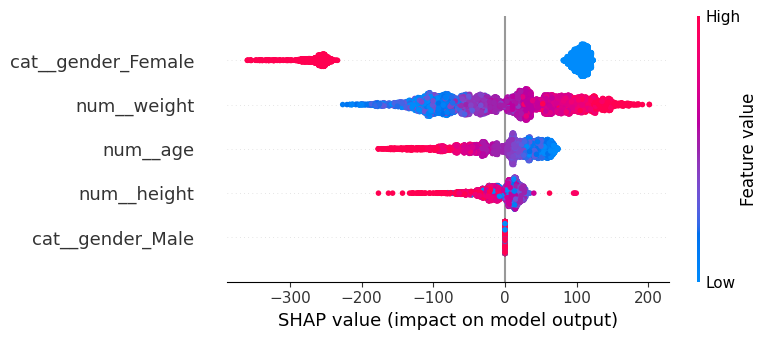

[codecarbon WARNING @ 21:06:00] Tracker already stopped !
[codecarbon INFO @ 21:06:00] Energy consumed for RAM : 0.000006 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:06:01] Delta energy consumed for CPU with cpu_load : 0.000016 kWh, power : 9.093822988000001 W
[codecarbon INFO @ 21:06:01] Energy consumed for All CPU : 0.000020 kWh
[codecarbon INFO @ 21:06:01] 0.000027 kWh of electricity used since the beginning.


Training version v1 with params {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


[codecarbon WARNING @ 21:06:03] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:06:03] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 21:06:03] [setup] RAM Tracking...
[codecarbon INFO @ 21:06:03] [setup] CPU Tracking...
[codecarbon WARNING @ 21:06:03] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 21:06:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:06:03] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 21:06:03] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:06:03] [setup] GPU Tracking...
[codecarbon INFO @ 21:06:03] No GPU found.
[codecarbon INFO @ 21:06:03] The 


 Results for Version: v1 | Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
   - RMSE: 166.5438
   - R² Score: 0.6403
   - CO₂ Emissions: 0.0000 kg


/home/spark-945f98e1-2ac5-462c-a777-8f/.ipykernel/15189/command-7047106937824224-2268491866:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


   - SHAP summary plot


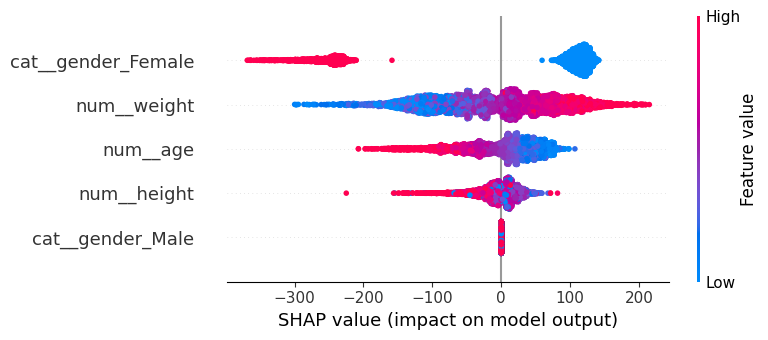

[codecarbon WARNING @ 21:06:13] Tracker already stopped !
[codecarbon INFO @ 21:06:13] Energy consumed for RAM : 0.000008 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:06:13] Delta energy consumed for CPU with cpu_load : 0.000024 kWh, power : 10.8910744375 W
[codecarbon INFO @ 21:06:13] Energy consumed for All CPU : 0.000028 kWh
[codecarbon INFO @ 21:06:13] 0.000036 kWh of electricity used since the beginning.


Training version v2 with params {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}


[codecarbon WARNING @ 21:06:16] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:06:16] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 21:06:16] [setup] RAM Tracking...
[codecarbon INFO @ 21:06:16] [setup] CPU Tracking...
[codecarbon WARNING @ 21:06:16] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 21:06:16] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:06:16] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 21:06:16] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:06:16] [setup] GPU Tracking...
[codecarbon INFO @ 21:06:16] No GPU found.
[codecarbon INFO @ 21:06:16] The 


 Results for Version: v2 | Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
   - RMSE: 26.8584
   - R² Score: 0.9906
   - CO₂ Emissions: 0.0000 kg


/home/spark-945f98e1-2ac5-462c-a777-8f/.ipykernel/15189/command-7047106937824224-2268491866:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


   - SHAP summary plot


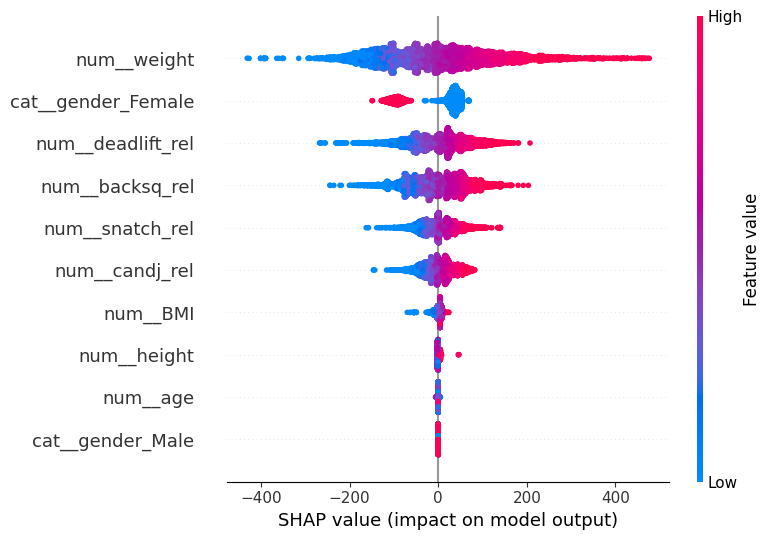

[codecarbon WARNING @ 21:06:24] Tracker already stopped !
[codecarbon INFO @ 21:06:24] Energy consumed for RAM : 0.000006 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:06:25] Delta energy consumed for CPU with cpu_load : 0.000040 kWh, power : 22.892137550499996 W
[codecarbon INFO @ 21:06:25] Energy consumed for All CPU : 0.000044 kWh
[codecarbon INFO @ 21:06:25] 0.000050 kWh of electricity used since the beginning.


Training version v2 with params {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


[codecarbon WARNING @ 21:06:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 21:06:28] Error while trying to count physical CPUs: invalid literal for int() with base 10: '-'. Defaulting to 1.
[codecarbon INFO @ 21:06:28] [setup] RAM Tracking...
[codecarbon INFO @ 21:06:28] [setup] CPU Tracking...
[codecarbon WARNING @ 21:06:28] We were unable to detect your CPU using the `cpuinfo` package. Resorting to a default power consumption.
[codecarbon WARNING @ 21:06:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:06:28] CPU Model on constant consumption mode: Unknown
[codecarbon WARNING @ 21:06:28] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:06:28] [setup] GPU Tracking...
[codecarbon INFO @ 21:06:28] No GPU found.
[codecarbon INFO @ 21:06:28] The 


 Results for Version: v2 | Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}
   - RMSE: 19.1281
   - R² Score: 0.9952
   - CO₂ Emissions: 0.0000 kg


/home/spark-945f98e1-2ac5-462c-a777-8f/.ipykernel/15189/command-7047106937824224-2268491866:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


   - SHAP summary plot


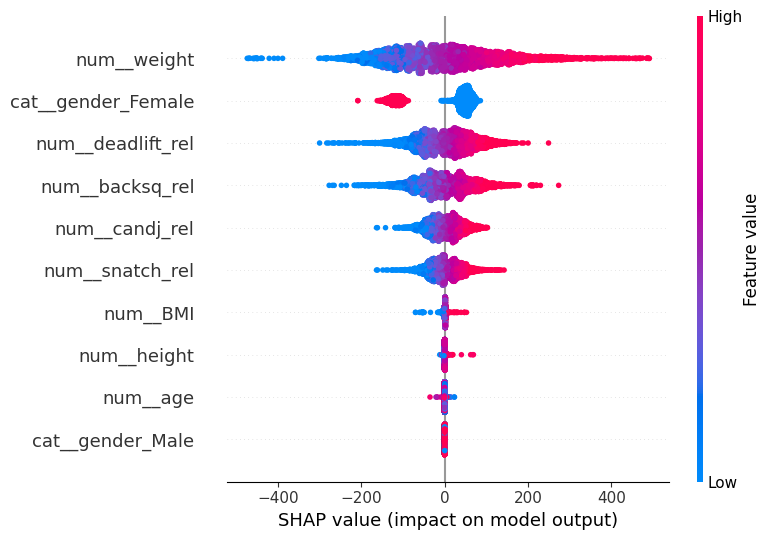

[codecarbon WARNING @ 21:06:41] Tracker already stopped !
[codecarbon INFO @ 21:06:41] Energy consumed for RAM : 0.000010 kWh. RAM Power : 3.0 W
[codecarbon INFO @ 21:06:42] Delta energy consumed for CPU with cpu_load : 0.000024 kWh, power : 10.179328000000002 W
[codecarbon INFO @ 21:06:42] Energy consumed for All CPU : 0.000082 kWh
[codecarbon INFO @ 21:06:42] 0.000092 kWh of electricity used since the beginning.


In [0]:
params1 = {"n_estimators": 100, "max_depth": 3, "learning_rate": 0.1}
params2 = {"n_estimators": 200, "max_depth": 5, "learning_rate": 0.05}

results = []

for version in ["v1", "v2"]:
    for params in [params1, params2]:
        print(f"Training version {version} with params {params}")
        res = train_pipeline(version, params)
        results.append(res)

## Comparisons: Model Metrics & Carbon Emissions 

In [0]:
# results table 
params_list = [params1, params2] 

table_data = []
for i, res in enumerate(results):
    params = params_list[i % 2]  
    table_data.append({
        "Version": res["version"],
        "n_estimators": params["n_estimators"],
        "max_depth": params["max_depth"],
        "learning_rate": params["learning_rate"],
        "RMSE": res["rmse"],
        "R²": res["r2"],
        "CO2 Emissions (kg)": res["carbon_emissions_kg"],
    })

df_results = pd.DataFrame(table_data)

df_results

,Version,n_estimators,max_depth,learning_rate,RMSE,R²,CO2 Emissions (kg)
0,v1,100,3,0.10,166.358852,0.641063,0.000004
1,v1,200,5,0.05,166.543782,0.640264,0.000004
2,v2,100,3,0.10,26.858388,0.990592,0.000004
3,v2,200,5,0.05,19.128123,0.995228,0.000041


### Quantitative Analysis
Version 2 of the dataset consistently yielded much lower RMSE values and higher R² scores compared to version 1. The best performing model uses datset version 2 with the following hyperparameters: 200 estimators, max tree depth of 5, and a learning rate of 0.05. This improvement is expected, as version 2 included additional features that enhanced the model's predictive capabilities. Across both dataset versions, the XGBoost models showed similar performance regardless of the hyperparameter configuration, although the second hyperparameter set slightly outperformed the first in version 2 more noticeably than in version 1. In terms of environmental impact, all models exhibited comparably low CO₂ emissions, with the fourth model (version 2 using the second hyperparameter set) generating marginally higher emissions.

### Qualitative Analysis (Shap Feature Importance)

For the models trained on version 1 of the data (models 1 and 2), the SHAP plots identify the gender "female" as the most important feature, while the gender "male" is the least important. Both models show the same relative ordering of feature importance, suggesting consistent patterns within this dataset version. In contrast, models trained on version 2 of the data (models 3 and 4), which include additional features, highlight a different most important feature: "weight" takes precedence, while "male" remains the least important. These two models also share the same relative feature rankings, mirroring the consistency seen in models 1 and 2. Comparing across dataset versions, the addition of new features in version 2 shifts the predictive emphasis from gender to physical attributes such as weight, reflecting improved model interpretability and a richer representation of the data in the second version.
